In [66]:
#출처 https://yunwoong.tistory.com/73
# %pip install opencv-python
# %pip install imutils
# %pip install scipy
# %pip install matplotlib
# %pip install pytesseract
# %pip install requests

In [67]:
from imutils.perspective import four_point_transform
from imutils.contours import sort_contours
import matplotlib.pyplot as plt
import pytesseract
import imutils
import cv2
import re
import requests
import numpy as np

In [68]:
def plt_imshow(title='image', img=None, figsize=(8 ,5)):
    plt.figure(figsize=figsize)
 
    if type(img) == list:
        if type(title) == list:
            titles = title
        else:
            titles = []
 
            for i in range(len(img)):
                titles.append(title)
 
        for i in range(len(img)):
            if len(img[i].shape) <= 2:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_GRAY2RGB)
            else:
                rgbImg = cv2.cvtColor(img[i], cv2.COLOR_BGR2RGB)
 
            plt.subplot(1, len(img), i + 1), plt.imshow(rgbImg)
            plt.title(titles[i])
            plt.xticks([]), plt.yticks([])
 
        plt.show()
    else:
        if len(img.shape) < 3:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
        else:
            rgbImg = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
 
        plt.imshow(rgbImg)
        plt.title(title)
        plt.xticks([]), plt.yticks([])
        plt.show()

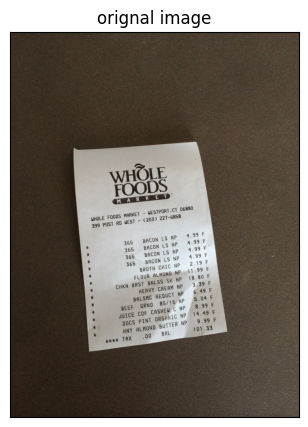

In [69]:
url = 'https://user-images.githubusercontent.com/69428232/148330274-237d9b23-4a79-4416-8ef1-bb7b2b52edc4.jpg'
 
image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
 
plt_imshow("orignal image", org_image)

In [70]:
options = "--psm 4"
org_text = pytesseract.image_to_string(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB), config=options)
 
# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(org_text)
print("\n")

[INFO] OCR결과:
1 - wesTPo
903) 227-6858

yHOLE FOODS MARKE
399 post RD WEST ~ ;






In [71]:
def make_scan_image(image, width, ksize=(5,5), min_threshold=75, max_threshold=200):
  image_list_title = []
  image_list = []
 
  org_image = image.copy()
  image = imutils.resize(image, width=width)
  ratio = org_image.shape[1] / float(image.shape[1])
 
  # 이미지를 grayscale로 변환하고 blur를 적용
  # 모서리를 찾기위한 이미지 연산
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  blurred = cv2.GaussianBlur(gray, ksize, 0)
  edged = cv2.Canny(blurred, min_threshold, max_threshold)
 
  image_list_title = ['gray', 'blurred', 'edged']
  image_list = [gray, blurred, edged]
 
  # contours를 찾아 크기순으로 정렬
  cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  cnts = imutils.grab_contours(cnts)
  cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
 
  findCnt = None
 
  # 정렬된 contours를 반복문으로 수행하며 4개의 꼭지점을 갖는 도형을 검출
  for c in cnts:
    peri = cv2.arcLength(c, True)
    approx = cv2.approxPolyDP(c, 0.02 * peri, True)
 
    # contours가 크기순으로 정렬되어 있기때문에 제일 첫번째 사각형을 영역으로 판단하고 break
    if len(approx) == 4:
      findCnt = approx
      break
 
  # 만약 추출한 윤곽이 없을 경우 오류
  if findCnt is None:
    raise Exception(("Could not find outline."))
 
  output = image.copy()
  cv2.drawContours(output, [findCnt], -1, (0, 255, 0), 2)
  
  image_list_title.append("Outline")
  image_list.append(output)
 
  # 원본 이미지에 찾은 윤곽을 기준으로 이미지를 보정
  transform_image = four_point_transform(org_image, findCnt.reshape(4, 2) * ratio)
 
  plt_imshow(image_list_title, image_list)
  plt_imshow("Transform", transform_image)
 
  return transform_image

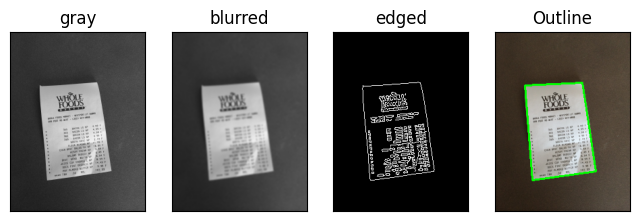

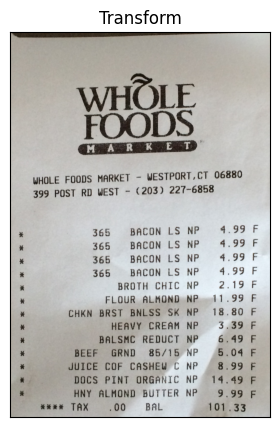

In [72]:
receipt_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [73]:
options = "--psm 4"
text = pytesseract.image_to_string(cv2.cvtColor(receipt_image, cv2.COLOR_BGR2RGB), config=options)
 
# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")

[INFO] OCR결과:
WHOLE
FOODS

WHOLE FOODS MARKET - WESTPORT, CT 06880
399 POST RD WEST - (203) 227-6858

365 BACON LS NP 4.99

365 BACON LS NP 4.99

365 BACON LS NP 99

365 BACON LS NP 4.99
BROTH CHIC NP rae

FLOUR ALMOND NP 11.99

CHKN BRST BNLSS SK NP 18.80
HEAVY CREAM NP 3.39

BALSMC REDUCT NP 6.49

BEEF GRND 85/15 NP 5.04
JUICE COF CASHEW C NP 8.99
DOCS PINT ORGANIC NP 14.49
HNY ALMOND BUTTER NP 9.99
eee TAX .00 BAL 101.33





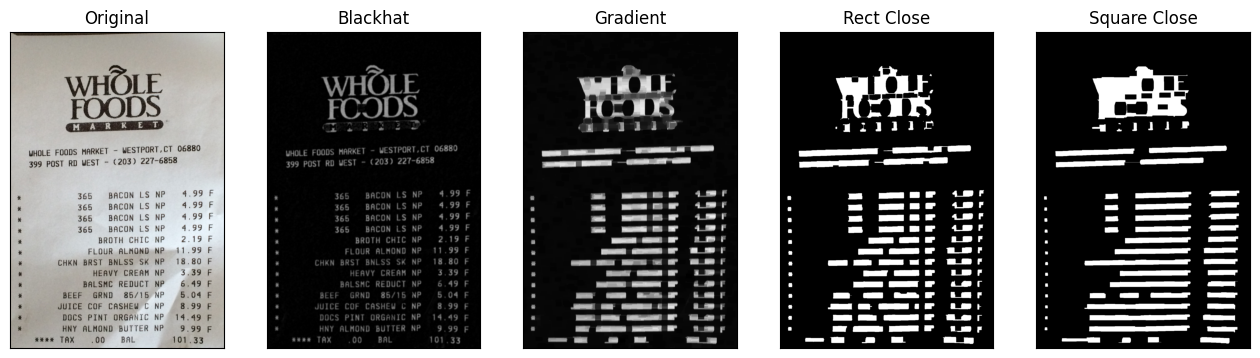

In [74]:
gray = cv2.cvtColor(receipt_image, cv2.COLOR_BGR2GRAY)
(H, W) = gray.shape
 
rectKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 20))
sqKernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 21))
 
gray = cv2.GaussianBlur(gray, (11, 11), 0)
blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, rectKernel)
 
grad = cv2.Sobel(blackhat, ddepth=cv2.CV_32F, dx=1, dy=0, ksize=-1)
grad = np.absolute(grad)
(minVal, maxVal) = (np.min(grad), np.max(grad))
grad = (grad - minVal) / (maxVal - minVal)
grad = (grad * 255).astype("uint8")
 
grad = cv2.morphologyEx(grad, cv2.MORPH_CLOSE, rectKernel)
thresh = cv2.threshold(grad, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
 
close_thresh = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, sqKernel)
close_thresh = cv2.erode(close_thresh, None, iterations=2)
 
plt_imshow(["Original", "Blackhat", "Gradient", "Rect Close", "Square Close"], [receipt_image, blackhat, grad, thresh, close_thresh], figsize=(16, 10))

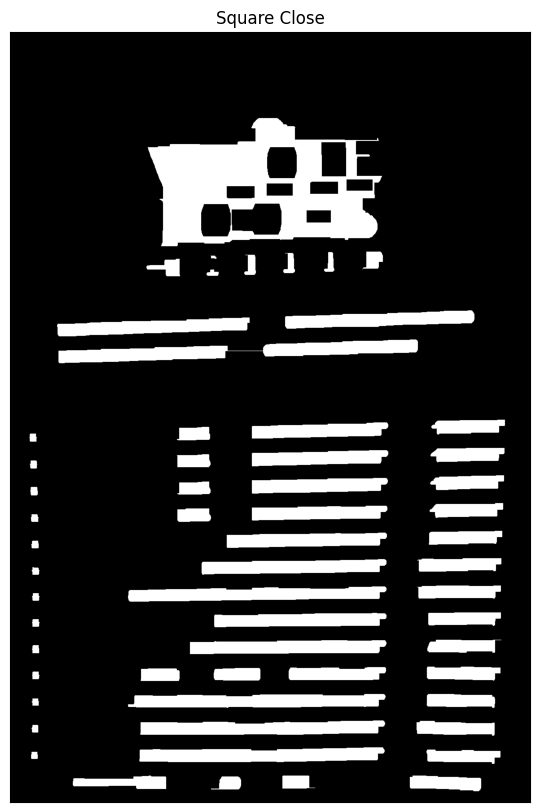

In [75]:
plt_imshow(["Square Close"], [close_thresh], figsize=(16, 10))

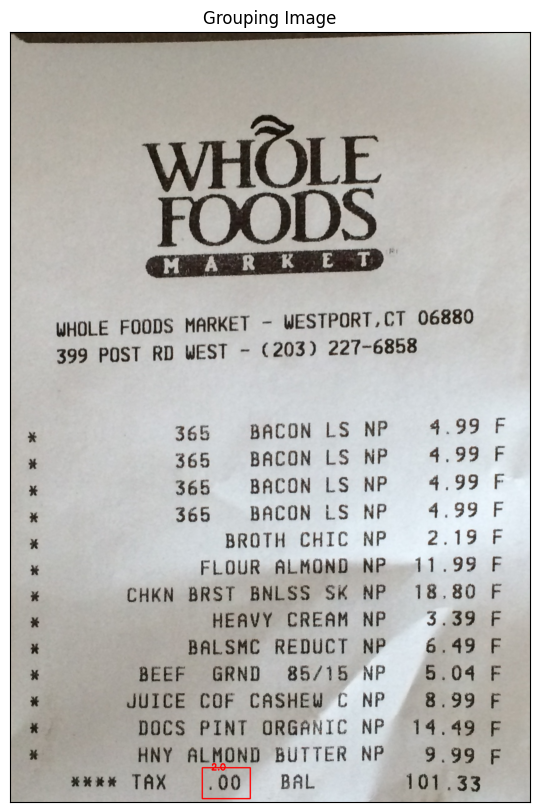

In [76]:
cnts = cv2.findContours(close_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sort_contours(cnts, method="top-to-bottom")[0]
 
roi_list = []
roi_title_list = []
 
margin = 20
receipt_grouping = receipt_image.copy()
 
for c in cnts:
  (x, y, w, h) = cv2.boundingRect(c)
  ar = w // float(h)
 
  if ar > 3.0 and ar < 6.5 and (W/2) < x:
    color = (0, 255, 0)
    roi = receipt_image[y - margin:y + h + margin, x - margin:x + w + margin]
    roi_list.append(roi)
    roi_title_list.append("Roi_{}".format(len(roi_list)))
  else:
    color = (0, 0, 255)
 
cv2.rectangle(receipt_grouping, (x - margin, y - margin), (x + w + margin, y + h + margin), color, 2)
cv2.putText(receipt_grouping, "".join(str(ar)), (x, y - 15), cv2.FONT_HERSHEY_SIMPLEX, 0.65, color, 2)

plt_imshow(["Grouping Image"], [receipt_grouping], figsize=(16, 10))

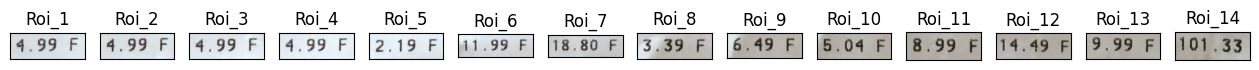

4.99 F

4.99 F

4.99 F

4.99 F

2.19 F

11.99 F

18.80 F

3.39 F

6.49 F

5.04 F

8.99 F

14.49 F

9.99 F

101.33



In [77]:
plt_imshow(roi_title_list, roi_list, figsize=(16, 10))
 
for roi in roi_list:
  gray_roi= cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
  threshold_roi = cv2.threshold(gray_roi, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]
  roi_text = pytesseract.image_to_string(threshold_roi)
  print(roi_text)

In [78]:
def mergeResize(img, row=300, col=200):
    IMG_COL = col #66
 
    # row값에 따른 col값 변경
    IMG_COL = int((row * IMG_COL)/row)
 
    IMG_ROW = row
    border_v = 0
    border_h = 0
 
    if (IMG_COL / IMG_ROW) >= (img.shape[0] / img.shape[1]):
        border_v = int((((IMG_COL / IMG_ROW) * img.shape[1]) - img.shape[0]) / 2)
    else:
        border_h = int((((IMG_ROW / IMG_COL) * img.shape[0]) - img.shape[1]) / 2)
    img = cv2.copyMakeBorder(img, top=border_v, bottom=border_v, left=0, right=border_h + border_h, borderType=cv2.BORDER_CONSTANT, value=(255, 255, 255))
    img = cv2.resize(img, (IMG_ROW, IMG_COL))
    return img

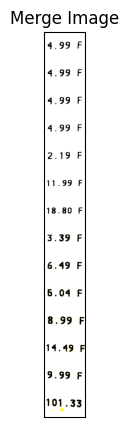

In [79]:
for idx, roi in enumerate(roi_list):
  if idx == 0:
    mergeImg = mergeResize(roi)
  else:
    cropImg = mergeResize(roi)
    mergeImg = np.concatenate((mergeImg, cropImg), axis=0)
    
threshold_mergeImg = cv2.threshold(mergeImg, 150, 255, cv2.THRESH_BINARY)[1]
plt_imshow(["Merge Image"], [threshold_mergeImg])
merge_Img_text = pytesseract.image_to_string(threshold_mergeImg)
print(merge_Img_text)

In [80]:
phoneNums = re.findall(r'[\+\(]?[1-9][0-9 .\-\(\)]{8,}[0-9]', text)
phoneNums

['(203) 227-6858']

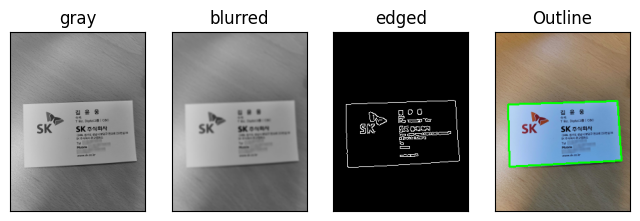

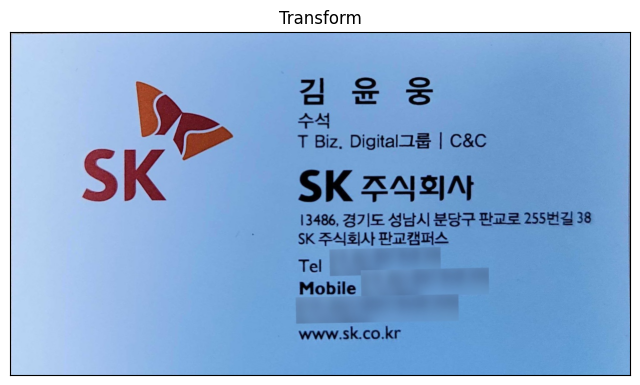

In [81]:
url = 'https://user-images.githubusercontent.com/69428232/155486780-55525c3c-8f5f-4313-8590-dd69d4ce4111.jpg'
 
image_nparray = np.asarray(bytearray(requests.get(url).content), dtype=np.uint8)
org_image = cv2.imdecode(image_nparray, cv2.IMREAD_COLOR) 
 
business_card_image = make_scan_image(org_image, width=200, ksize=(5, 5), min_threshold=20, max_threshold=100)

In [82]:
options = "--psm 4"
text = pytesseract.image_to_string(business_card_image, config=options, lang='kor+eng')
 
# OCR결과 출력
print("[INFO] OCR결과:")
print("==================")
print(text)
print("\n")

[INFO] OCR결과:
tA
T Biz, Digital | C&C

SK Z4413)At

13486, B7|= SEAl HS Bias 25H 38
SK EAYSIAf Bhat yA

Tel
Mobile

www.sk.co.kr



